In [114]:
import re
import numpy as np
import matplotlib.pyplot as plt
import sys

In [115]:
def checkandextract(data_list):
    data = 0
    if data_list:
        data = float (data_list[0])
    return data

class myTime:       
    def __init__(self, hours, minutes, seconds):
        
        self.hours = checkandextract(hours)
        self.minutes = checkandextract(minutes)
        self.seconds = checkandextract(seconds)
        
    def getTotalSeconds(self):
        time_s = self.hours * 3600 + self.minutes * 60 + self.seconds
        return time_s
    
    def getTimeStandar(self):
        time_string = "%02d:%02d:%05.2f"%(self.hours,self.minutes,self.seconds)
        return time_string
    
    def printTimeStandar(self):
        print("%02d:%02d:%05.2f"%(self.hours,self.minutes,self.seconds))

In [116]:
def get_pwscf_cpu_time_line(line):
    x = re.search(r"PWSCF  ", line)
    if x is not None:
        no_spaces = []
        y = re.split('CPU',x.string)
        y = re.split(' ',y[0])
    
        for string in y:
            if string != '':
                no_spaces.append(string)
        string = no_spaces[0]
        for i in range(len(no_spaces)-1):
            string = string + no_spaces[i+1]

        ho = re.findall(r"(\d+)h",string)
        mi = re.findall(r"(\d+)m",string)
        se = re.findall(r"([0-9.0-9]*\d+)s",string)
      
        time = myTime(ho, mi, se)
           
        return time
    return None

def get_pwscf_cpu_time(text):
    for line in text:
        time = get_pwscf_cpu_time_line(line)
        if time is not None:
            return time
        
    return None

In [117]:
def get_init_wall_time_line(line):
    x = re.search(r"init_run   ", line)
    if x is not None:
        no_spaces = []
        y = re.split('CPU',x.string)
        y = re.split(' ',y[1])
    
        for string in y:
            if string != '':
                no_spaces.append(string)
        string = no_spaces[0]
        for i in range(len(no_spaces)-1):
            string = string + no_spaces[i+1]

        ho = re.findall(r"(\d+)h",string)
        mi = re.findall(r"(\d+)m",string)
        se = re.findall(r"([0-9.0-9]*\d+)s",string)
        
        time = myTime(ho, mi, se)
           
        return time
    return None

def get_pwscf_wall_time(text):
    for line in text:
        time = get_init_wall_time_line(line)
        if time is not None:
            return time
        
    return None

In [118]:
def get_init_cpu_time_line(line):
    x = re.search(r"init_run   ", line)
    if x is not None:
        y = x.string.split()
        se = re.findall(r"([0-9.0-9]*\d+)s",y[2])
        
        time = myTime([],[],se)

        return time
    return None

def get_init_cpu_time(text):
    for line in text:
        time = get_init_cpu_time_line(line)
        if time is not None:
            return time
        
    return None

In [119]:
def get_electrons_cpu_time_line(line):
    x = re.search(r"electrons    :", line)
    if x is not None:
        y = x.string.split()
        se = re.findall(r"([0-9.0-9]*\d+)s",y[2])
        
        time = myTime([],[],se)

        return time
    return None

def get_electrons_cpu_time(text):
    for line in text:
        time = get_electrons_cpu_time_line(line)
        if time is not None:
            return time
        
    return None

In [120]:
def isJobDone(text):
    for line in text:
        x = re.search(r"JOB DONE", line)
        if x is not None:
            return True
            break
    return False

In [121]:
def getFunctional(text):
    for line in text:
        x = re.search(r"Exchange-correlation= ", line)
        if x is not None:
            y = re.split(r'=',line)
            functional = y[1].strip()
            return functional
    return None

In [122]:
def getNumAtomsPerCell(text):
    for line in text:
        x = re.search(r"number of atoms/cell      =", line)
        if x is not None:
            y = re.split(r'=',line)
            natom = int(y[1].strip())
            return natom
    return None

In [123]:
def getNumElectrons(text):
    for line in text:
        x = re.search(r"number of electrons       =", line)
        if x is not None:
            y = re.split(r'=',line)
            nelectron = float(y[1].strip())
            return nelectron
    return None

In [124]:
def getNumCores(text):
    for line in text:
        x = re.search(r"Parallel version", line)
        if x is not None:
            y = x.string.split()
            return int(y[-1])
    return None

In [125]:
def getMPIprocesses(text):
    for line in text:
        x = re.search(r"Number of MPI processes:", line)
        if x is not None:
            y = x.string.split()
            return int(y[4])
    return None

In [126]:
def getThreadsPerMPI(text):
    for line in text:
        x = re.search(r"Threads/MPI process:", line)
        if x is not None:
            y = x.string.split()
            return int(y[2])
    return None

In [127]:
def getNumNodes(text):
    for line in text:
        x = re.search(r"MPI processes distributed on", line)
        if x is not None:
            y = x.string.split()
            return int(y[4])
    return None

In [128]:
def getVersion(text):
    for line in text:
        x = re.search(r"Program PWSCF",line)
        if x is not None:
            y = x.string.split()
            return y[2]
    return None

In [146]:
def getGPUAcceleration(text):
    for line in text:
        x = re.search(r"GPU acceleration",line)
        if x is not None:
            y = x.string.split()
            return y[3].rstrip(y[3][-1])
    return None

In [147]:
def parserQEpwscf(fname):
    try:
        with open(fname,"r") as file:
            text = file.readlines()
            tot_cpu_time = get_pwscf_cpu_time(text)
            tot_wall_time = get_pwscf_wall_time(text)
            status = isJobDone(text)
            funct = getFunctional(text)
            natoms = getNumAtomsPerCell(text)
            nelect = getNumElectrons(text)
          #  ncores = getNumCores(text)
            nmpi = getMPIprocesses(text)
            nthr = getThreadsPerMPI(text)
            nnodes = getNumNodes(text)
            init_cpu_time = get_init_cpu_time(text)
            electrons_cpu_time = get_electrons_cpu_time(text)
            version = getVersion(text)
            gpuacc = getGPUAcceleration(text)
        
    except IOError as error:
        print('Error to open file: {0}'.format(fname))
        quit()
    else:
        print(" PWSCF Version  : ",version)
        print("Status job done : ",status)
        print("Acceleration GPU: ",gpuacc)
        print("   CPU     time : ", tot_cpu_time.getTotalSeconds())
        print("   WALL    time : ", tot_wall_time.getTotalSeconds())
        print("   Init    time : ", init_cpu_time.getTotalSeconds())
        print(" Electrons time : ", electrons_cpu_time.getTotalSeconds())
        print(" XC Functional  : ", funct)
        print(" Num of Atoms   : ", natoms)
        print(" Num electrons  : ", nelect)
        print(" Num cores      : ", ncores)
        print(" MPI processes  : ", nmpi)
        print(" Threads / MPI  : ", nthr)
        print(" Num nodes      : ", nnodes)
    
    

In [148]:
parserQEpwscf("data/16.pwo")

 PWSCF Version  :  v.7.1
Status job done :  True
Acceleration GPU:  ACTIVE
   CPU     time :  168.84
   WALL    time :  12.17
   Init    time :  10.18
 Electrons time :  158.29
 XC Functional  :  BEEF-VDW
 Num of Atoms   :  30
 Num electrons  :  529.0
 Num cores      :  16
 MPI processes  :  16
 Threads / MPI  :  1
 Num nodes      :  1


In [149]:
parserQEpwscf("data/CuCO2.pwo")

 PWSCF Version  :  v.7.1
Status job done :  True
Acceleration GPU:  None
   CPU     time :  16800.0
   WALL    time :  131.15
   Init    time :  158.69
 Electrons time :  16097.32
 XC Functional  :  BEEF-VDW
 Num of Atoms   :  30
 Num electrons  :  529.0
 Num cores      :  16
 MPI processes  :  None
 Threads / MPI  :  None
 Num nodes      :  1


In [133]:
def averagetime (list_strings):
    avg_time = 0
    for string in list_strings:
        t = get_pwscf_cpu_time_line(string)
        avg_time += t.getTotalSeconds()
    
    avg_time /= len(list_strings)
    return avg_time

In [134]:
# MPI_1
bin01=['PWSCF        :   2m54.47s CPU   2m58.44s WALL']

bin02=['PWSCF        :   2m54.58s CPU   5m52.04s WALL',
       'PWSCF        :   2m57.95s CPU   5m55.47s WALL'
      ]

bin03=['PWSCF        :   2m56.05s CPU   3m 0.21s WALL',
       'PWSCF        :   2m55.19s CPU   2m59.47s WALL',
       'PWSCF        :   2m55.23s CPU   2m59.12s WALL'
      ]

bin04=['PWSCF        :   3m 0.86s CPU   3m12.18s WALL',
       'PWSCF        :   2m54.48s CPU   3m 5.91s WALL',
       'PWSCF        :   2m55.83s CPU   3m 5.85s WALL',
       'PWSCF        :   2m56.84s CPU   3m 6.15s WALL'
      ]

bin08=['PWSCF        :   5m 6.71s CPU   5m11.11s WALL', 
       'PWSCF        :   5m 2.40s CPU   5m 6.70s WALL',
       'PWSCF        :   5m 1.24s CPU   5m 5.97s WALL',
       'PWSCF        :   5m 1.40s CPU   5m 5.25s WALL',
       'PWSCF        :   5m13.23s CPU   5m17.39s WALL',
       'PWSCF        :   5m19.86s CPU   5m24.35s WALL',
       'PWSCF        :   4m50.44s CPU   4m54.21s WALL',
       'PWSCF        :   4m50.92s CPU   4m54.85s WALL'
      ]

bin16=['PWSCF        :   7m 1.49s CPU   7m 8.09s WALL',
       'PWSCF        :   7m 7.57s CPU   7m13.40s WALL',
       'PWSCF        :   7m38.74s CPU   7m45.32s WALL',
       'PWSCF        :   7m37.09s CPU   7m43.70s WALL',
       'PWSCF        :   7m15.96s CPU   7m22.64s WALL',
       'PWSCF        :   7m13.56s CPU   7m19.09s WALL',
       'PWSCF        :   7m47.99s CPU   7m54.13s WALL',
       'PWSCF        :   7m46.19s CPU   7m52.40s WALL',
       'PWSCF        :   7m26.49s CPU   7m32.52s WALL',
       'PWSCF        :   7m23.10s CPU   7m29.22s WALL',
       'PWSCF        :   7m38.99s CPU   7m45.16s WALL',
       'PWSCF        :   7m26.39s CPU   7m32.82s WALL',
       'PWSCF        :   6m50.56s CPU   6m56.16s WALL',
       'PWSCF        :   7m 6.30s CPU   7m12.24s WALL',
       'PWSCF        :   7m50.38s CPU   7m57.71s WALL',
       'PWSCF        :   7m35.04s CPU   7m41.46s WALL'
      ]

In [135]:
print(" MPI 1  bin01: %6.2f s"%averagetime(bin01))
print(" MPI 1  bin02: %6.2f s"%averagetime(bin02))
print(" MPI 1  bin03: %6.2f s"%averagetime(bin03))
print(" MPI 1  bin04: %6.2f s"%averagetime(bin04))
print(" MPI 1  bin08: %6.2f s"%averagetime(bin08))
print(" MPI 1  bin16: %6.2f s"%averagetime(bin16))

time_mpi1 = np.array([averagetime(bin01), averagetime(bin02), 
             averagetime(bin03), averagetime(bin04), 
             averagetime(bin08), averagetime(bin16)])

 MPI 1  bin01: 174.47 s
 MPI 1  bin02: 176.26 s
 MPI 1  bin03: 175.49 s
 MPI 1  bin04: 177.00 s
 MPI 1  bin08: 303.28 s
 MPI 1  bin16: 445.37 s


In [136]:
# MPI_2
bin01=['PWSCF        :   3m13.97s CPU   4m 1.12s WALL']

bin02=['PWSCF        :   3m15.73s CPU   4m 4.63s WALL',
       'PWSCF        :   3m11.90s CPU   4m 0.61s WALL'
      ]

bin03=['PWSCF        :   3m11.90s CPU   4m 0.61s WALL',
       'PWSCF        :   3m23.79s CPU   4m 5.55s WALL',
       'PWSCF        :   3m19.53s CPU   4m 0.22s WALL'
      ]

bin04=['PWSCF        :   3m17.25s CPU   3m59.65s WALL',
       'PWSCF        :   3m12.79s CPU   3m54.05s WALL',
       'PWSCF        :   3m 9.64s CPU   3m51.51s WALL',
       'PWSCF        :   3m18.39s CPU   4m 1.09s WALL'
      ]

bin08=['PWSCF        :   2m45.53s CPU   6m37.59s WALL',
       'PWSCF        :   2m49.71s CPU   6m46.98s WALL',
       'PWSCF        :   3m 9.68s CPU   7m29.00s WALL',
       'PWSCF        :   3m12.97s CPU   7m31.92s WALL',
       'PWSCF        :   3m 3.48s CPU   7m16.40s WALL',
       'PWSCF        :   3m 0.68s CPU   7m 2.35s WALL',
       'PWSCF        :   3m13.00s CPU   7m34.66s WALL',
       'PWSCF        :   3m12.99s CPU   7m28.53s WALL'
      ]

bin16=['PWSCF        :   4m12.74s CPU   9m41.21s WALL',
       'PWSCF        :   4m13.30s CPU   9m46.70s WALL',
       'PWSCF        :   4m42.64s CPU  10m41.56s WALL',
       'PWSCF        :   4m39.45s CPU  10m34.98s WALL',
       'PWSCF        :   4m23.86s CPU  10m 3.03s WALL',
       'PWSCF        :   4m25.56s CPU  10m14.44s WALL',
       'PWSCF        :   4m25.32s CPU  10m10.87s WALL',
       'PWSCF        :   4m29.22s CPU  10m18.80s WALL',
       'PWSCF        :   4m23.75s CPU  10m 2.24s WALL',
       'PWSCF        :   4m37.28s CPU  10m33.57s WALL',
       'PWSCF        :   4m31.78s CPU  10m25.54s WALL',
       'PWSCF        :   4m34.44s CPU  10m25.39s WALL',
       'PWSCF        :   3m58.69s CPU   9m13.80s WALL',
       'PWSCF        :   4m30.77s CPU  10m20.35s WALL',
       'PWSCF        :   4m40.77s CPU  10m38.09s WALL',
       'PWSCF        :   4m41.02s CPU  10m38.61s WALL'
      ]

In [137]:
print(" MPI 2  bin01: %6.2f s"%averagetime(bin01))
print(" MPI 2  bin02: %6.2f s"%averagetime(bin02))
print(" MPI 2  bin03: %6.2f s"%averagetime(bin03))
print(" MPI 2  bin04: %6.2f s"%averagetime(bin04))
print(" MPI 2  bin08: %6.2f s"%averagetime(bin08))
print(" MPI 2  bin16: %6.2f s"%averagetime(bin16))
time_mpi2 = np.array([averagetime(bin01), averagetime(bin02), 
             averagetime(bin03), averagetime(bin04), 
             averagetime(bin08), averagetime(bin16)])


 MPI 2  bin01: 193.97 s
 MPI 2  bin02: 193.81 s
 MPI 2  bin03: 198.41 s
 MPI 2  bin04: 194.52 s
 MPI 2  bin08: 183.51 s
 MPI 2  bin16: 268.16 s


In [138]:
# MPI_4
bin01=['PWSCF        :   2m 4.55s CPU   5m16.40s WALL']

bin02=['PWSCF        :   2m 6.77s CPU   5m22.09s WALL',
       'PWSCF        :   2m 3.93s CPU   5m12.96s WALL'
      ]

bin03=['PWSCF        :   2m 0.64s CPU   5m 0.23s WALL',
       'PWSCF        :   2m 0.08s CPU   4m59.27s WALL',
       'PWSCF        :   2m 6.44s CPU   5m10.09s WALL'
      ]

bin04=['PWSCF        :   2m 5.69s CPU   5m12.35s WALL',
       'PWSCF        :   2m 4.92s CPU   5m13.19s WALL',
       'PWSCF        :   2m 4.16s CPU   5m 8.44s WALL',
       'PWSCF        :   2m 5.85s CPU   5m11.56s WALL'
      ]

bin08=['PWSCF        :   1m42.07s CPU   8m41.19s WALL',
       'PWSCF        :   1m45.14s CPU   8m57.53s WALL',
       'PWSCF        :   1m55.56s CPU   9m42.95s WALL',
       'PWSCF        :   1m54.82s CPU   9m35.17s WALL',
       'PWSCF        :   1m46.56s CPU   9m 2.18s WALL',
       'PWSCF        :   1m48.47s CPU   9m12.61s WALL',
       'PWSCF        :   1m48.20s CPU   9m 7.82s WALL',
       'PWSCF        :   1m48.38s CPU   9m 6.53s WALL'
      ]

bin16=['PWSCF        :   2m44.07s CPU  13m33.84s WALL',
       'PWSCF        :   2m45.89s CPU  13m41.87s WALL',
       'PWSCF        :   2m43.55s CPU  13m39.86s WALL',
       'PWSCF        :   2m42.03s CPU  13m31.10s WALL',
       'PWSCF        :   2m48.67s CPU  13m49.34s WALL',
       'PWSCF        :   2m51.35s CPU  14m 6.10s WALL',
       'PWSCF        :   2m44.44s CPU  13m45.95s WALL',
       'PWSCF        :   2m44.99s CPU  13m43.89s WALL',
       'PWSCF        :   2m44.19s CPU  13m30.43s WALL',
       'PWSCF        :   2m44.51s CPU  13m35.73s WALL',
       'PWSCF        :   2m45.04s CPU  13m43.18s WALL',
       'PWSCF        :   2m46.22s CPU  13m43.16s WALL',
       'PWSCF        :   2m41.31s CPU  13m23.32s WALL',
       'PWSCF        :   2m39.44s CPU  13m19.37s WALL',
       'PWSCF        :   2m49.99s CPU  14m 5.62s WALL',
       'PWSCF        :   2m51.69s CPU  14m 7.55s WALL'
      ]

In [139]:
print(" MPI 4  bin01: %6.2f s"%averagetime(bin01))
print(" MPI 4  bin02: %6.2f s"%averagetime(bin02))
print(" MPI 4  bin03: %6.2f s"%averagetime(bin03))
print(" MPI 4  bin04: %6.2f s"%averagetime(bin04))
print(" MPI 4  bin08: %6.2f s"%averagetime(bin08))
print(" MPI 4  bin16: %6.2f s"%averagetime(bin16))
time_mpi4 = np.array([averagetime(bin01), averagetime(bin02), 
             averagetime(bin03), averagetime(bin04), 
             averagetime(bin08), averagetime(bin16)])

 MPI 4  bin01: 124.55 s
 MPI 4  bin02: 125.35 s
 MPI 4  bin03: 122.39 s
 MPI 4  bin04: 125.16 s
 MPI 4  bin08: 108.65 s
 MPI 4  bin16: 165.46 s


In [140]:
# MPI_4
bin01=['PWSCF        :   1m41.06s CPU   8m24.31s WALL']

bin02=['PWSCF        :   1m39.51s CPU   8m15.30s WALL',
       'PWSCF        :   1m38.17s CPU   8m 6.63s WALL'
      ]

bin03=['PWSCF        :   1m41.46s CPU   8m20.35s WALL',
       'PWSCF        :   1m40.38s CPU   8m18.39s WALL',
       'PWSCF        :   1m39.14s CPU   8m13.56s WALL'
      ]

bin04=['PWSCF        :   1m37.65s CPU   8m 5.50s WALL', 
       'PWSCF        :   1m39.08s CPU   8m13.69s WALL', 
       'PWSCF        :   1m39.71s CPU   8m15.12s WALL', 
       'PWSCF        :   1m39.73s CPU   8m11.90s WALL'
      ]

bin08=['PWSCF        :   1m23.62s CPU  14m 5.01s WALL',
       'PWSCF        :   1m21.19s CPU  13m40.55s WALL',
       'PWSCF        :   1m28.29s CPU  14m42.68s WALL',
       'PWSCF        :   1m27.17s CPU  14m33.53s WALL',
       'PWSCF        :   1m25.65s CPU  14m25.46s WALL',
       'PWSCF        :   1m26.40s CPU  14m23.25s WALL',
       'PWSCF        :   1m24.23s CPU  14m 5.51s WALL',
       'PWSCF        :   1m24.85s CPU  14m 6.77s WALL'
      ]

bin16=['PWSCF        :     52.32s CPU   9m 4.52s WALL',
       'PWSCF        :   1m23.43s CPU  14m 5.39s WALL',
       'PWSCF        :   1m23.34s CPU  14m 4.92s WALL',
       'PWSCF        :   1m19.01s CPU  13m18.04s WALL',
       'PWSCF        :   1m20.38s CPU  13m39.29s WALL',
       'PWSCF        :     50.32s CPU   8m46.78s WALL'
      ]


In [141]:
print(" MPI 8  bin01: %6.2f s"%averagetime(bin01))
print(" MPI 8  bin02: %6.2f s"%averagetime(bin02))
print(" MPI 8  bin03: %6.2f s"%averagetime(bin03))
print(" MPI 8  bin04: %6.2f s"%averagetime(bin04))
print(" MPI 8  bin08: %6.2f s"%averagetime(bin08))
print(" MPI 8  bin16: %6.2f s"%averagetime(bin08))
time_mpi8 = np.array([averagetime(bin01), averagetime(bin02), 
             averagetime(bin03), averagetime(bin04), 
             averagetime(bin08), averagetime(bin16)])

 MPI 8  bin01: 101.06 s
 MPI 8  bin02:  98.84 s
 MPI 8  bin03: 100.33 s
 MPI 8  bin04:  99.04 s
 MPI 8  bin08:  85.17 s
 MPI 8  bin16:  85.17 s


<IPython.core.display.Javascript object>


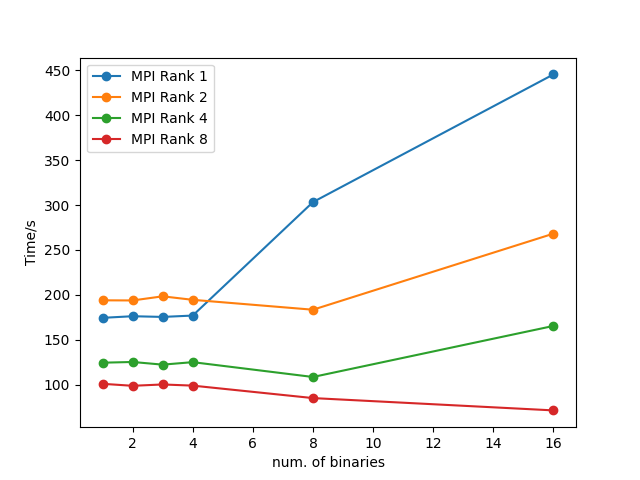

In [142]:
%matplotlib notebook
x_data=np.array([1,2,3,4,8,16])
plt.plot(x_data, time_mpi1, marker = 'o', label = 'MPI Rank 1')
plt.plot(x_data, time_mpi2, marker = 'o', label = 'MPI Rank 2')
plt.plot(x_data, time_mpi4, marker = 'o', label = 'MPI Rank 4')
plt.plot(x_data, time_mpi8, marker = 'o', label = 'MPI Rank 8')
plt.ylabel('Time/s')
plt.xlabel('num. of binaries')
plt.legend()
plt.show()
